In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import csv
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tensorflow as tf
import tensorflow_probability as tfp
import warnings

from tensorflow_probability import edward2 as ed

plt.style.use('ggplot')

C:\Users\james\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def load_insteval():
  url = ('https://raw.github.com/vincentarelbundock/Rdatasets/master/csv/'
         'lme4/InstEval.csv')
  with requests.Session() as s:
    download = s.get(url)
    f = download.content.decode().splitlines()

  iterator = csv.reader(f)
  columns = next(iterator)[1:]
  x_train = np.array([row[1:] for row in iterator], dtype=np.int)
  metadata = {'columns': columns}
  return x_train, metadata

In [3]:
load_insteval()[0].shape

(73421, 7)

In [4]:
data, metadata = load_insteval()
data = pd.DataFrame(data, columns=metadata['columns'])
data = data.rename(columns={'s': 'students',
                            'd': 'instructors',
                            'dept': 'departments',
                            'y': 'ratings'})

In [5]:
data

,students,instructors,studage,lectage,service,departments,ratings
0,1,1002,2,2,0,2,5
1,1,1050,2,1,1,6,2
2,1,1582,2,2,0,2,5
3,1,2050,2,2,1,3,3
4,2,115,2,1,0,5,2
5,2,756,2,1,0,5,4
6,3,7,2,1,1,11,4
7,3,13,2,1,0,10,5
8,3,36,2,1,0,10,5
9,3,140,2,1,0,10,4


(array([10186.,     0., 12951.,     0.,     0., 17609.,     0., 16921.,
            0., 15754.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

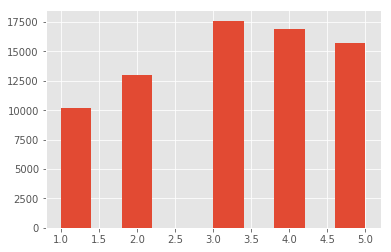

In [39]:
plt.hist(data["ratings"])

In [6]:
data['students'] -= 1  # start index by 0
data['instructors'] = data['instructors'].astype('category').cat.codes
data['departments'] = data['departments'].astype('category').cat.codes

In [7]:
data.info()
data.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73421 entries, 0 to 73420
Data columns (total 7 columns):
students       73421 non-null int32
instructors    73421 non-null int16
studage        73421 non-null int32
lectage        73421 non-null int32
service        73421 non-null int32
departments    73421 non-null int8
ratings        73421 non-null int32
dtypes: int16(1), int32(5), int8(1)
memory usage: 1.6 MB


students       int32
instructors    int16
studage        int32
lectage        int32
service        int32
departments     int8
ratings        int32
dtype: object

In [8]:
train = data.sample(frac=0.8)
test = data.drop(train.index)
train.head()

,students,instructors,studage,lectage,service,departments,ratings
8569,321,608,4,5,1,8,1
64444,2615,59,6,2,0,13,2
35232,1432,1057,8,4,0,5,4
58793,2378,107,6,6,1,3,2
2952,120,505,6,5,1,7,3


(array([8102., 7095., 6877., 7185., 7344., 7544., 7719., 6916., 6939.,
        7700.]),
 array([   0. ,  297.1,  594.2,  891.3, 1188.4, 1485.5, 1782.6, 2079.7,
        2376.8, 2673.9, 2971. ]),
 <a list of 10 Patch objects>)

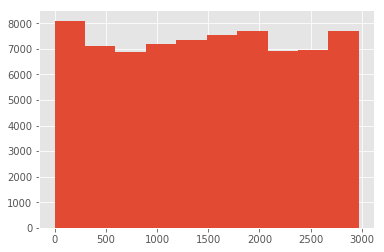

In [9]:
plt.hist(data["students"])

(array([8478., 8034., 7045., 7751., 7383., 6761., 5849., 6440., 9481.,
        6199.]),
 array([   0. ,  112.7,  225.4,  338.1,  450.8,  563.5,  676.2,  788.9,
         901.6, 1014.3, 1127. ]),
 <a list of 10 Patch objects>)

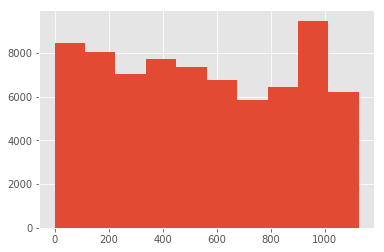

In [10]:
plt.hist(data["instructors"])

(array([20125.,     0., 16297.,     0., 10999.,     0.,  8638.,     0.,
         6258., 11104.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

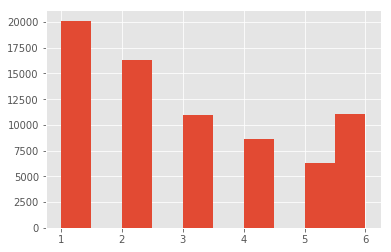

In [11]:
plt.hist(data["lectage"])

In [12]:
get_value = lambda dataframe, key, dtype: dataframe[key].values.astype(dtype)
features_train = {
    k: get_value(train, key=k, dtype=np.int32)
    for k in ['students', 'instructors', 'departments', 'service']}
labels_train = get_value(train, key='ratings', dtype=np.float32)

features_test = {k: get_value(test, key=k, dtype=np.int32)
                 for k in ['students', 'instructors', 'departments', 'service']}
labels_test = get_value(test, key='ratings', dtype=np.float32)

In [13]:
num_students = max(features_train['students']) + 1
num_instructors = max(features_train['instructors']) + 1
num_departments = max(features_train['departments']) + 1
num_observations = train.shape[0]

print("Number of students:", num_students)
print("Number of instructors:", num_instructors)
print("Number of departments:", num_departments)
print("Number of observations:", num_observations)

Number of students: 2972
Number of instructors: 1128
Number of departments: 14
Number of observations: 58737


In [14]:
def linear_mixed_effects_model(features):

    intercept = tf.get_variable("intercept", [])  # alpha in eq
    effect_service = tf.get_variable("effect_service", [])  # beta in eq
    stddev_students = tf.exp(tf.get_variable("stddev_unconstrained_students", []))  # sigma in eq
    stddev_instructors = tf.exp(tf.get_variable("stddev_unconstrained_instructors", [])) # sigma in eq
    stddev_departments = tf.exp(tf.get_variable("stddev_unconstrained_departments", [])) # sigma in eq

    effect_students = ed.MultivariateNormalDiag(loc=tf.zeros(num_students),scale_identity_multiplier=stddev_students,name="effect_students")
    effect_instructors = ed.MultivariateNormalDiag(loc=tf.zeros(num_instructors),scale_identity_multiplier=stddev_instructors,name="effect_instructors")
    effect_departments = ed.MultivariateNormalDiag(loc=tf.zeros(num_departments),scale_identity_multiplier=stddev_departments,name="effect_departments")
    ratings = ed.Normal(loc=(effect_service * features["service"] +tf.gather(effect_students, features["students"]) +tf.gather(effect_instructors, features["instructors"]) +tf.gather(effect_departments, features["departments"]) +intercept),scale=1.,name="ratings")
    return ratings


In [15]:
model_template = tf.make_template("model", linear_mixed_effects_model)

In [16]:
def strip_consts(graph_def, max_const_size=32):
  """Strip large constant values from graph_def."""
  strip_def = tf.GraphDef()
  for n0 in graph_def.node:
    n = strip_def.node.add()
    n.MergeFrom(n0)
    if n.op == 'Const':
      tensor = n.attr['value'].tensor
      size = len(tensor.tensor_content)
      if size > max_const_size:
        tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
  return strip_def

def draw_graph(model, *args, **kwargs):
  """Visualize TensorFlow graph."""
  graph = tf.Graph()
  with graph.as_default():
    model(*args, **kwargs)
  graph_def = graph.as_graph_def()
  strip_def = strip_consts(graph_def, max_const_size=32)
  code = """
      <script>
        function load() {{
          document.getElementById("{id}").pbtxt = {data};
        }}
      </script>
      <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
      <div style="height:600px">
        <tf-graph-basic id="{id}"></tf-graph-basic>
      </div>
  """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

  iframe = """
      <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
  """.format(code.replace('"', '&quot;'))
  IPython.display.display(IPython.display.HTML(iframe))


draw_graph(linear_mixed_effects_model, features_train)

In [17]:
log_joint = ed.make_log_joint_fn(model_template)

In [18]:
def target_log_prob_fn(effect_students, effect_instructors, effect_departments):
  return log_joint(  # fix `features` and `ratings` to the training data
    features=features_train,
    effect_students=effect_students,
    effect_instructors=effect_instructors,
    effect_departments=effect_departments,
    ratings=labels_train)

In [19]:
tf.reset_default_graph()

In [20]:
effect_students = tf.get_variable(  # `trainable=False` so unaffected by M-step
    "effect_students", [num_students], trainable=False)
effect_instructors = tf.get_variable(
    "effect_instructors", [num_instructors], trainable=False)
effect_departments = tf.get_variable(
    "effect_departments", [num_departments], trainable=False)

In [21]:
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=0.015,
    num_leapfrog_steps=3)

In [22]:
current_state = [effect_students, effect_instructors, effect_departments]
next_state, kernel_results = hmc.one_step(
      current_state=current_state,
      previous_kernel_results=hmc.bootstrap_results(current_state))

In [23]:
kernel_results

MetropolisHastingsKernelResults(accepted_results=UncalibratedHamiltonianMonteCarloKernelResults(log_acceptance_correction=<tf.Tensor 'mh_one_step/choose_inner_results/Select:0' shape=() dtype=float32>, target_log_prob=<tf.Tensor 'mh_one_step/choose_inner_results_1/Select:0' shape=() dtype=float32>, grads_target_log_prob=[<tf.Tensor 'mh_one_step/choose_inner_results_2/Select:0' shape=(2972,) dtype=float32>, <tf.Tensor 'mh_one_step/choose_inner_results_2/Select_1:0' shape=(1128,) dtype=float32>, <tf.Tensor 'mh_one_step/choose_inner_results_2/Select_2:0' shape=(14,) dtype=float32>]), is_accepted=<tf.Tensor 'mh_one_step/Less:0' shape=() dtype=bool>, log_accept_ratio=<tf.Tensor 'mh_one_step/compute_log_accept_ratio/Sum:0' shape=() dtype=float32>, proposed_state=[<tf.Tensor 'mh_one_step/hmc_kernel_one_step/while/Exit_4:0' shape=(2972,) dtype=float32>, <tf.Tensor 'mh_one_step/hmc_kernel_one_step/while/Exit_5:0' shape=(1128,) dtype=float32>, <tf.Tensor 'mh_one_step/hmc_kernel_one_step/while/Ex

In [24]:
kernel_results.is_accepted

<tf.Tensor 'mh_one_step/Less:0' shape=() dtype=bool>

In [25]:
expectation_update = tf.group(
    effect_students.assign(next_state[0]),
    effect_instructors.assign(next_state[1]),
    effect_departments.assign(next_state[2]))

In [26]:
with tf.control_dependencies([expectation_update]):
  loss = -target_log_prob_fn(effect_students,
                             effect_instructors,
                             effect_departments)
  optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
  minimization_update = optimizer.minimize(loss)

In [27]:

init = tf.global_variables_initializer()

num_warmup_iters = 1000
num_iters = 1500
num_accepted = 0
effect_students_samples = np.zeros([num_iters, num_students])
effect_instructors_samples = np.zeros([num_iters, num_instructors])
effect_departments_samples = np.zeros([num_iters, num_departments])
loss_history = np.zeros([num_iters])

sess = tf.Session()
sess.run(init)


In [28]:
num_accepted = 0
for t in range(num_warmup_iters):
  _, is_accepted_val = sess.run(
      [expectation_update, kernel_results.is_accepted])
  num_accepted += is_accepted_val
  if t % 500 == 0 or t == num_warmup_iters - 1:
    print("Warm-Up Iteration: {:>3} Acceptance Rate: {:.3f}".format(
        t, num_accepted / (t + 1)))

Warm-Up Iteration:   0 Acceptance Rate: 1.000
Warm-Up Iteration: 500 Acceptance Rate: 0.800
Warm-Up Iteration: 999 Acceptance Rate: 0.755


In [29]:
num_accepted = 0
for t in range(num_iters):
  for _ in range(5):  # run 5 MCMC iterations before every joint EM update
    _ = sess.run(expectation_update)
  [
      _,
      _,
      effect_students_val,
      effect_instructors_val,
      effect_departments_val,
      is_accepted_val,
      loss_val,
  ] = sess.run([
      expectation_update,
      minimization_update,
      effect_students,
      effect_instructors,
      effect_departments,
      kernel_results.is_accepted,
      loss,
  ])
  effect_students_samples[t, :] = effect_students_val
  effect_instructors_samples[t, :] = effect_instructors_val
  effect_departments_samples[t, :] = effect_departments_val
  num_accepted += is_accepted_val
  loss_history[t] = loss_val
  if t % 500 == 0 or t == num_iters - 1:
    print("Iteration: {:>4} Acceptance Rate: {:.3f} Loss: {:.3f}".format(
        t, num_accepted / (t + 1), loss_val))

Iteration:    0 Acceptance Rate: 1.000 Loss: 104851.516
Iteration:  500 Acceptance Rate: 0.653 Loss: 95928.469
Iteration: 1000 Acceptance Rate: 0.674 Loss: 95859.148
Iteration: 1499 Acceptance Rate: 0.678 Loss: 95995.797


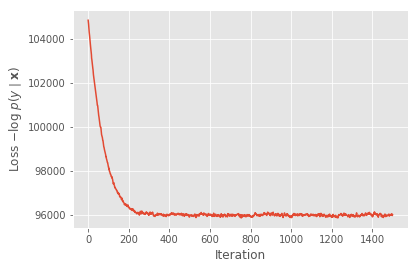

In [30]:
plt.plot(loss_history)
plt.ylabel(r'Loss $-\log$ $p(y\mid\mathbf{x})$')
plt.xlabel('Iteration')
plt.show()

In [36]:
def interceptor(rv_constructor, *rv_args, **rv_kwargs):
  """Replaces prior on effects with empirical posterior mean from MCMC."""
  name = rv_kwargs.pop("name")
  print(name)
  if name == "effect_students":
    rv_kwargs["value"] = np.mean(effect_students_samples, 0)
  elif name == "effect_instructors":
    rv_kwargs["value"] = np.mean(effect_instructors_samples, 0)
  elif name == "effect_departments":
    rv_kwargs["value"] = np.mean(effect_departments_samples, 0)
  return rv_constructor(*rv_args, **rv_kwargs)


In [38]:
model_template

In [37]:
with ed.interception(interceptor):
  ratings_posterior = model_template(features=features_test)

ratings_prediction = ratings_posterior.distribution.mean()

effect_students
effect_instructors
effect_departments
ratings


In [32]:
ratings_prediction

<tf.Tensor 'model_1/Normal_3/mean/mul:0' shape=(14684,) dtype=float32>

In [33]:
ratings_pred = sess.run(ratings_prediction)

In [34]:
ratings_pred

array([3.146294 , 4.253559 , 3.9727526, ..., 3.9559064, 3.812571 ,
       4.293586 ], dtype=float32)

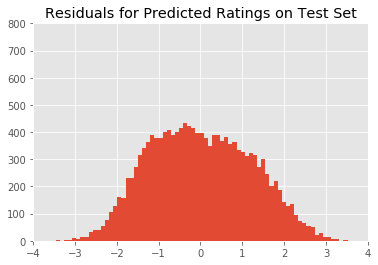

In [40]:
plt.title("Residuals for Predicted Ratings on Test Set")
plt.xlim(-4, 4)
plt.ylim(0, 800)
plt.hist(ratings_pred - labels_test, 75)
plt.show()

In [41]:
[
    effect_students_mean,
    effect_instructors_mean,
    effect_departments_mean,
] = sess.run([
    tf.reduce_mean(effect_students_samples, 0),
    tf.reduce_mean(effect_instructors_samples, 0),
    tf.reduce_mean(effect_departments_samples, 0),
])

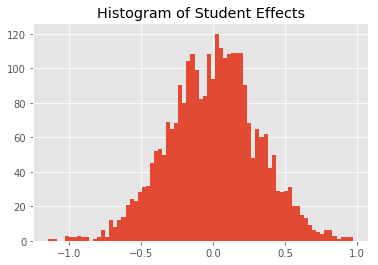

In [42]:
plt.title("Histogram of Student Effects")
plt.hist(effect_students_mean, 75)
plt.show()

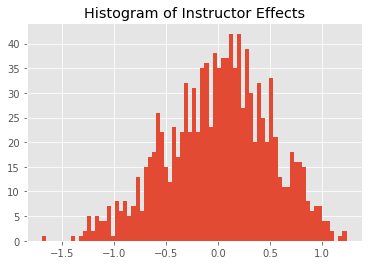

In [43]:
plt.title("Histogram of Instructor Effects")
plt.hist(effect_instructors_mean, 75)
plt.show()

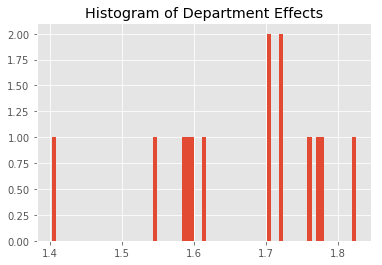

In [44]:
plt.title("Histogram of Department Effects")
plt.hist(effect_departments_mean, 75)
plt.show()